In [1]:
import json
from bpe import BPE
import torch
import torch.nn as nn
from model import Model
from model_trainer import train
import matplotlib.pyplot as plt
# from datasets import load_dataset

# dataset = load_dataset("roneneldan/TinyStories")
# train_text = dataset['train']['text']
# val_text = dataset['validation']['text']

with open("Saved_Data/train_data.json", "r") as f:
    corpus = json.load(f)

In [ ]:
tokenizer = BPE(vocab_size=512)
tokenizer.from_json("Saved_Vocab/vocab_v2.json")
tokenizer.EOS_TOKEN = "<EOS>"
tokenizer.PAD_TOKEN = "<PAD>"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONTEXT_LENGTH = 256
EMBEDDING_DIM = 128
D_MODEL = 256

model = Model(
    num_heads=8
    , d_model=D_MODEL
    , vocab_size=tokenizer.vocab_size
    , num_layers=3
    , dropout=0.3
    , context_length=CONTEXT_LENGTH
    , embedding_dim=EMBEDDING_DIM
    , padding_idx=tokenizer.encode_vocab[tokenizer.PAD_TOKEN]
    )
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

model.to(DEVICE)
model.train()

In [3]:
NUM_EPOCHS = 7
BATCH_SIZE = 128

In [ ]:
losses = []

In [ ]:
losses = train(
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    corpus = corpus,
    tokenizer = tokenizer,
    context_length = CONTEXT_LENGTH,
    num_epochs = 1,
    batch_size = BATCH_SIZE
)

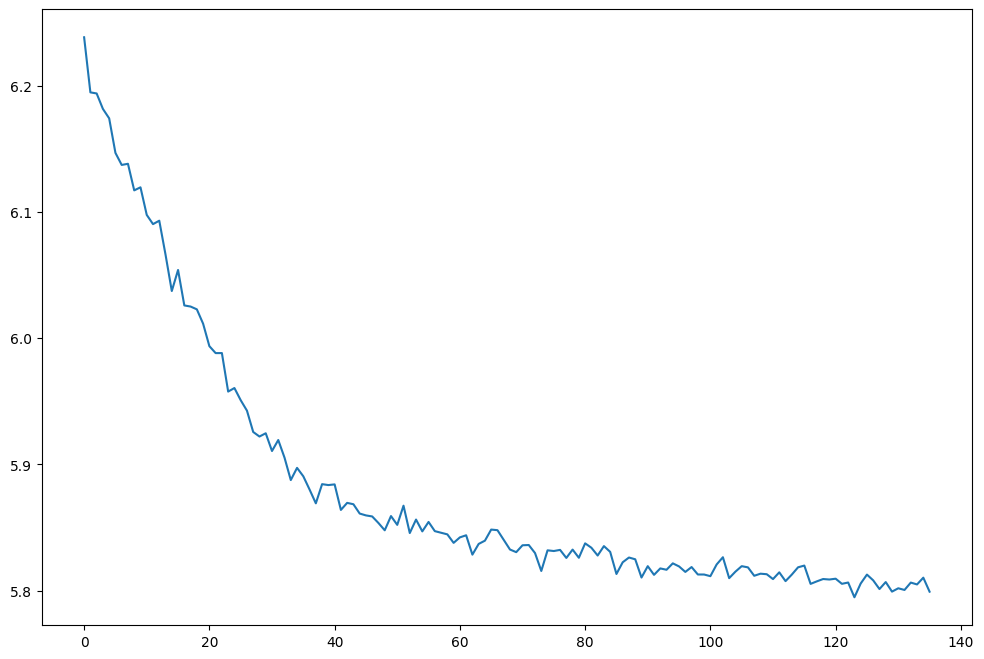

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(losses)
plt.savefig("Visualizations/model_v4_losses.png")

In [22]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5

In [27]:
def generate_text(model, tokenizer, context, length = 50):
    model.eval()
    with torch.no_grad():
        context = tokenizer.encode(context)
        context = context[:-1]
        context = torch.Tensor(context).long().to(DEVICE)
        for _ in range(length):
            y_pred = model(context.unsqueeze(0)[:,-CONTEXT_LENGTH:])
            next_token = torch.multinomial(y_pred[0, -1], 1).item()
            # next_token = torch.argmax(y_pred[0, -1]).item()
            if next_token == tokenizer.encode(tokenizer.EOS_TOKEN)[0]:
                break
            context = torch.cat([context, torch.Tensor([next_token]).long().to(DEVICE)])
    
    return tokenizer.decode(context)

In [33]:
generate_text(model, tokenizer, "Long ago there was a king", length = 350)

'Long ago there was a kingdom, who was feeling ready because it was bigger.\n\nOne day, the kingdom was feeling ready because it was bigger.\n\nSo the kingdom was feeling ready because it was bigger.\n\nSo the kingdom keper named Sam ready some bigger eyes, some bigger eyes, some bigger eyes, some bigger eyes, some bigger eyes, some bigger eyes.\n\nSam was surprised by the kingdom, who was surprised by the kingdom.\n\nSam was surprised by the kingdom, who was surprised by the kingdom was feeling ready because it was bigger eyes.\n\nSam was surprised by the kingdom was feeling ready because it was bigger eyes, it was time it was feeling ready because it was bigger eyes.\n\nSam was surprised by the kingdom was '

In [34]:
model_path = 'Saved_Models/model_v4.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
# model.load_state_dict(torch.load("Saved_Models/model_v4.pth"))
# model.eval()
# generate_text(model, "Once upon a time")

### Try len(encode) distplot for all vocab sizes and compare the results for insights